# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [5]:
def create_features(df):
    """
    与えられたデータフレームに対して特徴量エンジニアリングを行う関数。

    Args:
    df (DataFrame): 特徴量エンジニアリングを行うデータフレーム

    Returns:
    DataFrame: 新しい特徴量が追加されたデータフレーム
    """
    # キルとデスの比率
    df['killDeathRatio'] = df['blueKills'] / (df['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

    # アシストの割合
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)

    # ヘラルドの討伐数
    df['blueHerald'] = df['blueEliteMonsters'] - df['blueDragons']
    # blueHerald列の負の値を0で置き換え
    df['blueHerald'] = df['blueHerald'].clip(lower=0)

    # エリートモンスターとドラゴンの比率
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    # エリートモンスターとヘラルドの比率
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)

    # ゴールドと経験値の対数変換
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])

    # 初期キルの影響
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    
    # キル、デス、アシストの合計
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    # キル・デス・アシスト比率
    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    # チームの総合力
    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']

    return df

- Apply data

In [6]:
train = create_features(train)
test = create_features(test)

# 特徴量の効き

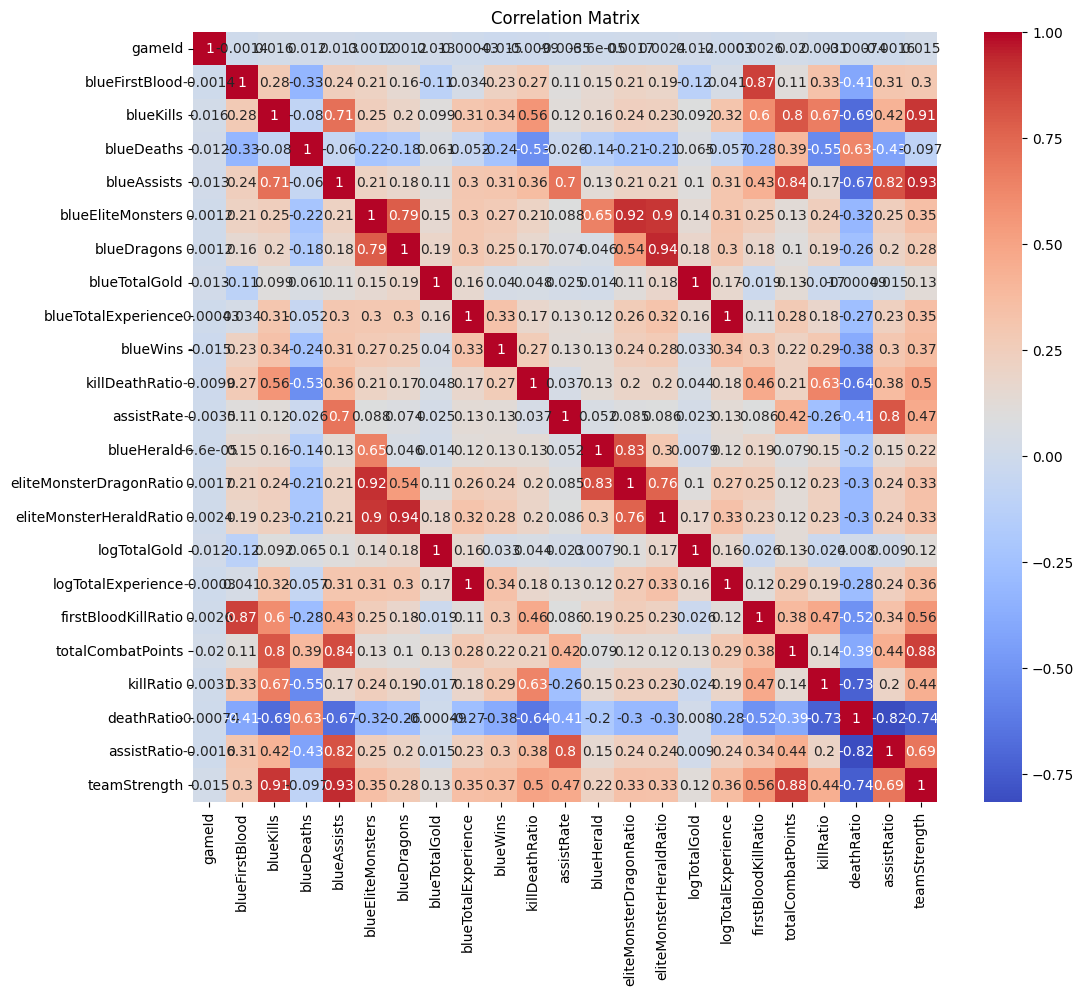

In [7]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- LightGBM

[I 2024-01-19 16:01:36,572] A new study created in memory with name: no-name-ab825279-5f17-4dea-adda-bed90e3e267d


[I 2024-01-19 16:01:36,689] Trial 0 finished with value: 0.799375 and parameters: {'lambda_l1': 1.9191401666086675e-06, 'lambda_l2': 8.822066338709948e-08, 'num_leaves': 14, 'feature_fraction': 0.9504477568670824, 'bagging_fraction': 0.7179747276832916, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 0 with value: 0.799375.
[I 2024-01-19 16:01:36,763] Trial 1 finished with value: 0.7775 and parameters: {'lambda_l1': 1.212717980873909e-06, 'lambda_l2': 0.0014199876299416732, 'num_leaves': 10, 'feature_fraction': 0.6068192204364119, 'bagging_fraction': 0.8466534169167288, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 0 with value: 0.799375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.2225
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:36,820] Trial 2 finished with value: 0.804375 and parameters: {'lambda_l1': 5.130934074796758e-05, 'lambda_l2': 2.683475883789979e-05, 'num_leaves': 104, 'feature_fraction': 0.9947822356141444, 'bagging_fraction': 0.5768496955920609, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 2 with value: 0.804375.
[I 2024-01-19 16:01:36,916] Trial 3 finished with value: 0.81 and parameters: {'lambda_l1': 0.19549385986983595, 'lambda_l2': 2.671360342209192e-07, 'num_leaves': 221, 'feature_fraction': 0.7771808690142843, 'bagging_fraction': 0.8721003739219836, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:36,983] Trial 4 finished with value: 0.7975 and parameters: {'lambda_l1': 7.015149343005929e-08, 'lambda_l2': 4.3675800930570645, 'num_leaves': 54, 'feature_fraction': 0.7957353480613469, 'bagging_fraction': 0.7510252094371768, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.2025
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:37,021] Trial 5 finished with value: 0.789375 and parameters: {'lambda_l1': 0.5830298373777194, 'lambda_l2': 1.339193148866393e-05, 'num_leaves': 141, 'feature_fraction': 0.4547537715916077, 'bagging_fraction': 0.5517847272808842, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:37,078] Trial 6 finished with value: 0.799375 and parameters: {'lambda_l1': 0.39901134949381745, 'lambda_l2': 0.2490016255412565, 'num_leaves': 148, 'feature_fraction': 0.8570924484403665, 'bagging_fraction': 0.6539687830814243, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:37,142] Trial 7 finished with value: 0.790625 and parameters: {'lambda_l1': 1.0104881319476962e-07, 'lambda_l2': 0.02367088884492468, 'num_leaves': 114, 'feature_fraction': 0.9769380055594905, 'bagging_fraction': 0.6509926506287766, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 3 with value: 0.81.
[I 2024-01-

Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.210625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.209375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.235625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:37,252] Trial 9 finished with value: 0.805 and parameters: {'lambda_l1': 4.6968931646606854e-05, 'lambda_l2': 0.05340585619357126, 'num_leaves': 68, 'feature_fraction': 0.4904857310412645, 'bagging_fraction': 0.6481651181259518, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:37,352] Trial 10 finished with value: 0.799375 and parameters: {'lambda_l1': 0.01376194851544305, 'lambda_l2': 8.151574983543327e-07, 'num_leaves': 244, 'feature_fraction': 0.6858725261153514, 'bagging_fraction': 0.4184290034868697, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:37,443] Trial 11 finished with value: 0.805625 and parameters: {'lambda_l1': 0.0009602507438830634, 'lambda_l2': 0.005427514341888979, 'num_leaves': 244, 'feature_fraction': 0.6186019937685091, 'bagging_fraction': 0.9400147888231227, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.194375


[I 2024-01-19 16:01:37,586] Trial 12 finished with value: 0.808125 and parameters: {'lambda_l1': 0.005891373016753628, 'lambda_l2': 0.0003733925263822746, 'num_leaves': 256, 'feature_fraction': 0.641101973237288, 'bagging_fraction': 0.9693763000748485, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:37,686] Trial 13 finished with value: 0.795625 and parameters: {'lambda_l1': 6.3377073900904906, 'lambda_l2': 9.728454189431269e-05, 'num_leaves': 193, 'feature_fraction': 0.7605808997293689, 'bagging_fraction': 0.9959999339472179, 'bagging_freq': 2, 'min_child_samples': 98}. Best is trial 3 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_error: 0.204375


[I 2024-01-19 16:01:37,798] Trial 14 finished with value: 0.8075 and parameters: {'lambda_l1': 0.012825614585124946, 'lambda_l2': 3.6603526444253044e-06, 'num_leaves': 194, 'feature_fraction': 0.6781857975590162, 'bagging_fraction': 0.8416497411471123, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:37,881] Trial 15 finished with value: 0.80625 and parameters: {'lambda_l1': 0.010783611962233087, 'lambda_l2': 0.0011689294973186103, 'num_leaves': 202, 'feature_fraction': 0.8534445877389343, 'bagging_fraction': 0.9991864155204118, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 3 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:38,034] Trial 16 finished with value: 0.800625 and parameters: {'lambda_l1': 0.14314389749409, 'lambda_l2': 0.00017143634758701908, 'num_leaves': 222, 'feature_fraction': 0.5528613795086585, 'bagging_fraction': 0.8500067952385244, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:38,144] Trial 17 finished with value: 0.809375 and parameters: {'lambda_l1': 0.0010115038816795113, 'lambda_l2': 8.396889987961033e-07, 'num_leaves': 256, 'feature_fraction': 0.40398856238793757, 'bagging_fraction': 0.9130007390681962, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.203125


[I 2024-01-19 16:01:38,235] Trial 18 finished with value: 0.796875 and parameters: {'lambda_l1': 6.848044851583095, 'lambda_l2': 5.832054313306513e-07, 'num_leaves': 171, 'feature_fraction': 0.4052808156535667, 'bagging_fraction': 0.8965095997485176, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:38,325] Trial 19 finished with value: 0.805625 and parameters: {'lambda_l1': 0.00033649192361341385, 'lambda_l2': 2.4575321117434557e-08, 'num_leaves': 220, 'feature_fraction': 0.5357120285102241, 'bagging_fraction': 0.7784940519840354, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:38,415] Trial 20 finished with value: 0.79875 and parameters: {'lambda_l1': 0.07215967529698188, 'lambda_l2': 1.5027811382899184e-07, 'num_leaves': 167, 'feature_fraction': 0.7436024823159768, 'bagging_fraction': 0.8884349069082069, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 3 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:38,549] Trial 21 finished with value: 0.809375 and parameters: {'lambda_l1': 0.0022232129132025453, 'lambda_l2': 4.797353329280842e-06, 'num_leaves': 252, 'feature_fraction': 0.6333820693550659, 'bagging_fraction': 0.9446026261069677, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:38,727] Trial 22 finished with value: 0.79375 and parameters: {'lambda_l1': 0.0011577274038692877, 'lambda_l2': 1.8519932404711238e-06, 'num_leaves': 236, 'feature_fraction': 0.5528159517196662, 'bagging_fraction': 0.9451315679036686, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.20625


[I 2024-01-19 16:01:38,889] Trial 23 finished with value: 0.80625 and parameters: {'lambda_l1': 0.002096960314652328, 'lambda_l2': 7.90012999165083e-06, 'num_leaves': 220, 'feature_fraction': 0.4085394756840376, 'bagging_fraction': 0.8045721972369285, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 3 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:39,032] Trial 24 finished with value: 0.80375 and parameters: {'lambda_l1': 0.04785407043677563, 'lambda_l2': 3.3581010475163506e-07, 'num_leaves': 256, 'feature_fraction': 0.5912964240685141, 'bagging_fraction': 0.8953960383169894, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:39,147] Trial 25 finished with value: 0.806875 and parameters: {'lambda_l1': 0.00011729857925922319, 'lambda_l2': 3.6887206189901366e-06, 'num_leaves': 208, 'feature_fraction': 0.6804384775284165, 'bagging_fraction': 0.9444568028876301, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:39,293] Trial 26 finished with value: 0.80375 and parameters: {'lambda_l1': 0.0003793404392137853, 'lambda_l2': 5.5197828683510656e-08, 'num_leaves': 175, 'feature_fraction': 0.7278151448651619, 'bagging_fraction': 0.8089599226135902, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:39,415] Trial 27 finished with value: 0.808125 and parameters: {'lambda_l1': 0.04645211870679455, 'lambda_l2': 3.160683218502341e-07, 'num_leaves': 230, 'feature_fraction': 0.5132117963699394, 'bagging_fraction': 0.8703715380975462, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:39,566] Trial 28 finished with value: 0.80375 and parameters: {'lambda_l1': 0.003427799978576846, 'lambda_l2': 3.5710077633515646e-05, 'num_leaves': 256, 'feature_fraction': 0.6355535777616641, 'bagging_fraction': 0.9164325259864038, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:39,691] Trial 29 finished with value: 0.809375 and parameters: {'lambda_l1': 1.0373393567809595e-05, 'lambda_l2': 6.316177066804883e-08, 'num_leaves': 181, 'feature_fraction': 0.5785672570795025, 'bagging_fraction': 0.9663707488939004, 'bagging_freq': 5, 'min_child_samples': 60}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:39,809] Trial 30 finished with value: 0.808125 and parameters: {'lambda_l1': 0.0014553287050837224, 'lambda_l2': 1.6683717576356359e-06, 'num_leaves': 208, 'feature_fraction': 0.49140092626100185, 'bagging_fraction': 0.8852156465115089, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:39,910] Trial 31 finished with value: 0.803125 and parameters: {'lambda_l1': 1.7086518164570742e-05, 'lambda_l2': 9.559264614814197e-08, 'num_leaves': 179, 'feature_fraction': 0.5971846361506347, 'bagging_fraction': 0.9717246387754697, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:40,000] Trial 32 finished with value: 0.8025 and parameters: {'lambda_l1': 7.712527603559181e-06, 'lambda_l2': 4.1868128699365415e-08, 'num_leaves': 221, 'feature_fraction': 0.5808668326230529, 'bagging_fraction': 0.9620525131556869, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:40,101] Trial 33 finished with value: 0.804375 and parameters: {'lambda_l1': 1.7578143206257106e-06, 'lambda_l2': 1.3781395972794414e-07, 'num_leaves': 239, 'feature_fraction': 0.6470130641288949, 'bagging_fraction': 0.9214109902692549, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:40,253] Trial 34 finished with value: 0.79125 and parameters: {'lambda_l1': 0.00016108800723084538, 'lambda_l2': 1.3664592101477908e-08, 'num_leaves': 148, 'feature_fraction': 0.569289354885395, 'bagging_fraction': 0.8489894304727701, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:40,354] Trial 35 finished with value: 0.809375 and parameters: {'lambda_l1': 0.0006666355574510504, 'lambda_l2': 6.903874904061201e-07, 'num_leaves': 187, 'feature_fraction': 0.711364792596809, 'bagging_fraction': 0.9777707230986933, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.20875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:40,477] Trial 36 finished with value: 0.804375 and parameters: {'lambda_l1': 8.431147541851952e-06, 'lambda_l2': 1.0954721795846263e-05, 'num_leaves': 85, 'feature_fraction': 0.7885100997751168, 'bagging_fraction': 0.9360607629530423, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:40,565] Trial 37 finished with value: 0.80625 and parameters: {'lambda_l1': 8.025924812858294e-05, 'lambda_l2': 1.8936648566737256e-07, 'num_leaves': 26, 'feature_fraction': 0.5289754800136189, 'bagging_fraction': 0.9978338058168001, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:40,709] Trial 38 finished with value: 0.780625 and parameters: {'lambda_l1': 9.229778259913288e-07, 'lambda_l2': 4.60933909306956e-08, 'num_leaves': 207, 'feature_fraction': 0.6619316388951075, 'bagging_fraction': 0.9135782361682532, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:40,820] Trial 39 finished with value: 0.808125 and parameters: {'lambda_l1': 0.00031584897047491785, 'lambda_l2': 1.163989378164461e-06, 'num_leaves': 127, 'feature_fraction': 0.7061547357008106, 'bagging_fraction': 0.8678854627563084, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.219375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:40,982] Trial 40 finished with value: 0.801875 and parameters: {'lambda_l1': 0.003939779280878346, 'lambda_l2': 2.3643769409630057e-05, 'num_leaves': 156, 'feature_fraction': 0.6089718221100662, 'bagging_fraction': 0.7542612071185752, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:41,081] Trial 41 finished with value: 0.80375 and parameters: {'lambda_l1': 0.0007568787637969329, 'lambda_l2': 3.9650439070956397e-07, 'num_leaves': 188, 'feature_fraction': 0.6960998908209428, 'bagging_fraction': 0.9690024267712123, 'bagging_freq': 5, 'min_child_samples': 97}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:41,202] Trial 42 finished with value: 0.8 and parameters: {'lambda_l1': 2.539903578763864e-05, 'lambda_l2': 8.517504787278326e-07, 'num_leaves': 235, 'feature_fraction': 0.6228272127110819, 'bagging_fraction': 0.9106383850147416, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:41,283] Trial 43 finished with value: 0.7975 and parameters: {'lambda_l1': 0.00014816574958211224, 'lambda_l2': 1.0292258449896354e-08, 'num_leaves': 161, 'feature_fraction': 0.45273808246972064, 'bagging_fraction': 0.951142801389487, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[36]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.2025
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.19875


[I 2024-01-19 16:01:41,400] Trial 44 finished with value: 0.80125 and parameters: {'lambda_l1': 0.0008095814072544204, 'lambda_l2': 1.195799888453367e-07, 'num_leaves': 248, 'feature_fraction': 0.7205858244441626, 'bagging_fraction': 0.9780055633775541, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:41,528] Trial 45 finished with value: 0.805625 and parameters: {'lambda_l1': 0.007070580501565752, 'lambda_l2': 5.907054520247835e-07, 'num_leaves': 185, 'feature_fraction': 0.6654722699029567, 'bagging_fraction': 0.9279376853520411, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:41,645] Trial 46 finished with value: 0.8025 and parameters: {'lambda_l1': 0.025956666012683247, 'lambda_l2': 4.291370072447746e-06, 'num_leaves': 119, 'feature_fraction': 0.8268099357167455, 'bagging_fraction': 0.9998654211266473, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 3 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.1975


[I 2024-01-19 16:01:41,738] Trial 47 finished with value: 0.805 and parameters: {'lambda_l1': 0.002588534836042157, 'lambda_l2': 3.303820022531107e-08, 'num_leaves': 214, 'feature_fraction': 0.7765463578339991, 'bagging_fraction': 0.9631796299637364, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:41,830] Trial 48 finished with value: 0.800625 and parameters: {'lambda_l1': 0.4658367019008645, 'lambda_l2': 1.8133864509663634e-06, 'num_leaves': 193, 'feature_fraction': 0.7478037890475671, 'bagging_fraction': 0.8710075246837432, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 3 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:41,927] Trial 49 finished with value: 0.7975 and parameters: {'lambda_l1': 0.01672875086291771, 'lambda_l2': 2.3347082501224205e-07, 'num_leaves': 229, 'feature_fraction': 0.6423366970633962, 'bagging_fraction': 0.9415116445063378, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:42,072] Trial 50 finished with value: 0.80625 and parameters: {'lambda_l1': 1.2449550201736135, 'lambda_l2': 6.61180858680828e-08, 'num_leaves': 199, 'feature_fraction': 0.7001740209541284, 'bagging_fraction': 0.9051291281422348, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.2025
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.19375


[I 2024-01-19 16:01:42,221] Trial 51 finished with value: 0.806875 and parameters: {'lambda_l1': 0.005887104596525923, 'lambda_l2': 6.517345946145999e-05, 'num_leaves': 249, 'feature_fraction': 0.626840925008282, 'bagging_fraction': 0.9839739433475142, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 3 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:42,371] Trial 52 finished with value: 0.80625 and parameters: {'lambda_l1': 0.00670383190435012, 'lambda_l2': 0.0007551916332349077, 'num_leaves': 244, 'feature_fraction': 0.6540372698096301, 'bagging_fraction': 0.9568602511282431, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 3 with value: 0.81.
[I 2024-01-19 16:01:42,503] Trial 53 finished with value: 0.800625 and parameters: {'lambda_l1': 0.16417476360233738, 'lambda_l2': 0.0002600547367349373, 'num_leaves': 256, 'feature_fraction': 0.592745516360851, 'bagging_fraction': 0.9754425895465606, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 3 with value: 0.81.


Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.199375


[I 2024-01-19 16:01:42,661] Trial 54 finished with value: 0.810625 and parameters: {'lambda_l1': 0.0027978654882010734, 'lambda_l2': 6.387815124446689e-06, 'num_leaves': 228, 'feature_fraction': 0.6810087640801055, 'bagging_fraction': 0.934344758720465, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:42,834] Trial 55 finished with value: 0.796875 and parameters: {'lambda_l1': 0.0004174267360335985, 'lambda_l2': 5.672334648333378e-06, 'num_leaves': 228, 'feature_fraction': 0.7260981962436885, 'bagging_fraction': 0.9261543750850406, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 54 with value: 0.810625.


Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.203125
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:43,016] Trial 56 finished with value: 0.799375 and parameters: {'lambda_l1': 0.0016770020869619367, 'lambda_l2': 1.4899472886470766e-05, 'num_leaves': 213, 'feature_fraction': 0.8140506603829666, 'bagging_fraction': 0.8951176781188427, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:43,155] Trial 57 finished with value: 0.80375 and parameters: {'lambda_l1': 0.000740051577318167, 'lambda_l2': 3.0621010081560384e-06, 'num_leaves': 237, 'feature_fraction': 0.7541605165587363, 'bagging_fraction': 0.9404541013471706, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 54 with value: 0.810625.


Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:43,269] Trial 58 finished with value: 0.805625 and parameters: {'lambda_l1': 0.019350217979422723, 'lambda_l2': 7.132900815486858e-07, 'num_leaves': 142, 'feature_fraction': 0.6730294290369444, 'bagging_fraction': 0.8392521502362141, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:43,370] Trial 59 finished with value: 0.785625 and parameters: {'lambda_l1': 0.002500185486186415, 'lambda_l2': 3.376591060190416e-07, 'num_leaves': 226, 'feature_fraction': 0.6881953029073424, 'bagging_fraction': 0.9843055870596664, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 54 with value: 0.810625.


Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_error: 0.214375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:43,499] Trial 60 finished with value: 0.808125 and parameters: {'lambda_l1': 7.453929135553318e-05, 'lambda_l2': 1.387791344758606e-06, 'num_leaves': 96, 'feature_fraction': 0.61374344646625, 'bagging_fraction': 0.8849901040527459, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:43,643] Trial 61 finished with value: 0.800625 and parameters: {'lambda_l1': 0.011477351414056449, 'lambda_l2': 8.08761511985904e-06, 'num_leaves': 246, 'feature_fraction': 0.6423448041060236, 'bagging_fraction': 0.9509972023297061, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 54 with value: 0.810625.


Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.199375


[I 2024-01-19 16:01:43,762] Trial 62 finished with value: 0.805625 and parameters: {'lambda_l1': 0.005104346319534761, 'lambda_l2': 6.652011469943787e-05, 'num_leaves': 238, 'feature_fraction': 0.5667029459781505, 'bagging_fraction': 0.9251110486984981, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:43,884] Trial 63 finished with value: 0.805625 and parameters: {'lambda_l1': 0.0015130819733828289, 'lambda_l2': 2.544730681945698e-06, 'num_leaves': 256, 'feature_fraction': 0.7103604963711657, 'bagging_fraction': 0.9779640637768784, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.194375


[I 2024-01-19 16:01:43,995] Trial 64 finished with value: 0.808125 and parameters: {'lambda_l1': 0.0004599344051258615, 'lambda_l2': 5.230011777084461e-07, 'num_leaves': 214, 'feature_fraction': 0.6665941755261913, 'bagging_fraction': 0.9538738599373299, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:44,146] Trial 65 finished with value: 0.801875 and parameters: {'lambda_l1': 0.002938325005837294, 'lambda_l2': 1.8196428571080363e-07, 'num_leaves': 246, 'feature_fraction': 0.7339509410562844, 'bagging_fraction': 0.9093270926175726, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.198125


[I 2024-01-19 16:01:44,297] Trial 66 finished with value: 0.79125 and parameters: {'lambda_l1': 0.001418814652395662, 'lambda_l2': 1.0835828636602271e-06, 'num_leaves': 201, 'feature_fraction': 0.6066398695653704, 'bagging_fraction': 0.93161625588145, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:44,398] Trial 67 finished with value: 0.80375 and parameters: {'lambda_l1': 0.00015527412104234661, 'lambda_l2': 1.0017035577453255e-07, 'num_leaves': 233, 'feature_fraction': 0.6822353634209857, 'bagging_fraction': 0.9644826753130791, 'bagging_freq': 2, 'min_child_samples': 68}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.20875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.19625


[I 2024-01-19 16:01:44,544] Trial 68 finished with value: 0.80875 and parameters: {'lambda_l1': 0.0002531021615491094, 'lambda_l2': 2.323734241346649e-08, 'num_leaves': 221, 'feature_fraction': 0.764646764842507, 'bagging_fraction': 0.9983603916479675, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:44,660] Trial 69 finished with value: 0.801875 and parameters: {'lambda_l1': 5.888971771999304e-05, 'lambda_l2': 2.3108419016757745e-08, 'num_leaves': 182, 'feature_fraction': 0.7668096170821358, 'bagging_fraction': 0.9992040543367897, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.198125


[I 2024-01-19 16:01:44,760] Trial 70 finished with value: 0.8075 and parameters: {'lambda_l1': 0.00025320986595048, 'lambda_l2': 8.370944326831978e-08, 'num_leaves': 217, 'feature_fraction': 0.7380661028569069, 'bagging_fraction': 0.9840517146060418, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:44,901] Trial 71 finished with value: 0.809375 and parameters: {'lambda_l1': 0.0006339367954081826, 'lambda_l2': 2.2046562918868413e-08, 'num_leaves': 225, 'feature_fraction': 0.6324878895443165, 'bagging_fraction': 0.9425060078934002, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.190625


[I 2024-01-19 16:01:44,994] Trial 72 finished with value: 0.80875 and parameters: {'lambda_l1': 0.0005532228973714598, 'lambda_l2': 2.1256288721365794e-08, 'num_leaves': 223, 'feature_fraction': 0.7096531299121114, 'bagging_fraction': 0.9386449813497134, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.189375


[I 2024-01-19 16:01:45,176] Trial 73 finished with value: 0.810625 and parameters: {'lambda_l1': 0.00023136971168022285, 'lambda_l2': 4.6748535503172535e-08, 'num_leaves': 208, 'feature_fraction': 0.7558034816513804, 'bagging_fraction': 0.9041728188962462, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:45,319] Trial 74 finished with value: 0.79625 and parameters: {'lambda_l1': 0.0008509205551906662, 'lambda_l2': 2.180066437665736e-07, 'num_leaves': 205, 'feature_fraction': 0.5461163908508299, 'bagging_fraction': 0.9057423967685285, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:45,447] Trial 75 finished with value: 0.799375 and parameters: {'lambda_l1': 4.444992728573738e-05, 'lambda_l2': 5.4043733595183736e-08, 'num_leaves': 195, 'feature_fraction': 0.6208919313890784, 'bagging_fraction': 0.8853986844501218, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 54 wit

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.200625


[I 2024-01-19 16:01:45,601] Trial 76 finished with value: 0.808125 and parameters: {'lambda_l1': 0.00020864671267670264, 'lambda_l2': 3.8129628612063484e-07, 'num_leaves': 164, 'feature_fraction': 0.5757604252175063, 'bagging_fraction': 0.9207046162305751, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:45,763] Trial 77 finished with value: 0.796875 and parameters: {'lambda_l1': 0.001188397161951071, 'lambda_l2': 1.376901882648502e-07, 'num_leaves': 172, 'feature_fraction': 0.6503123689493805, 'bagging_fraction': 0.8667280878610035, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:45,873] Trial 78 finished with value: 0.80625 and parameters: {'lambda_l1': 0.0005331123489573604, 'lambda_l2': 6.778142763971931e-08, 'num_leaves': 209, 'feature_fraction': 0.6915114358147101, 'bagging_fraction': 0.9588069202864516, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 54 with value: 0.810625.


Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.203125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.19375


[I 2024-01-19 16:01:46,057] Trial 79 finished with value: 0.799375 and parameters: {'lambda_l1': 0.00010136935134405572, 'lambda_l2': 3.446076732690284e-08, 'num_leaves': 189, 'feature_fraction': 0.4200076795671917, 'bagging_fraction': 0.9018733679594957, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 54 with value: 0.810625.
[I 2024-01-19 16:01:46,138] Trial 80 finished with value: 0.800625 and parameters: {'lambda_l1': 0.0039163080785820596, 'lambda_l2': 1.9912496728828424e-06, 'num_leaves': 31, 'feature_fraction': 0.49650545445440025, 'bagging_fraction': 0.9408778968155193, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 54 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.199375


[I 2024-01-19 16:01:46,278] Trial 81 finished with value: 0.813125 and parameters: {'lambda_l1': 0.00036693562298238615, 'lambda_l2': 1.5814511048534067e-08, 'num_leaves': 242, 'feature_fraction': 0.755882274364171, 'bagging_fraction': 0.9711748382084643, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 81 with value: 0.813125.
[I 2024-01-19 16:01:46,393] Trial 82 finished with value: 0.8075 and parameters: {'lambda_l1': 0.000264203788164917, 'lambda_l2': 1.7393557441187994e-08, 'num_leaves': 239, 'feature_fraction': 0.7478980404391224, 'bagging_fraction': 0.9212775199680617, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 81 with value: 0.813125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.186875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.1925


[I 2024-01-19 16:01:46,500] Trial 83 finished with value: 0.805625 and parameters: {'lambda_l1': 0.0018912942040265673, 'lambda_l2': 1.1034705131852018e-08, 'num_leaves': 231, 'feature_fraction': 0.7820077021349554, 'bagging_fraction': 0.9683139552761848, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 81 with value: 0.813125.
[I 2024-01-19 16:01:46,644] Trial 84 finished with value: 0.816875 and parameters: {'lambda_l1': 0.0009667705409724542, 'lambda_l2': 3.5294319150936484e-08, 'num_leaves': 250, 'feature_fraction': 0.7255230128418675, 'bagging_fraction': 0.962913506023813, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 84 with value: 0.816875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.183125


[I 2024-01-19 16:01:46,759] Trial 85 finished with value: 0.80625 and parameters: {'lambda_l1': 0.008015908036497056, 'lambda_l2': 4.323771947103036e-08, 'num_leaves': 248, 'feature_fraction': 0.714716466857517, 'bagging_fraction': 0.9592020406396241, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 84 with value: 0.816875.
[I 2024-01-19 16:01:46,887] Trial 86 finished with value: 0.8075 and parameters: {'lambda_l1': 0.00013124619743847915, 'lambda_l2': 2.439540070672256e-07, 'num_leaves': 250, 'feature_fraction': 0.7972372253465443, 'bagging_fraction': 0.9844213359994339, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 84 with value: 0.816875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.1925


[I 2024-01-19 16:01:47,017] Trial 87 finished with value: 0.8075 and parameters: {'lambda_l1': 0.0012533919109615405, 'lambda_l2': 9.725701254030907e-08, 'num_leaves': 241, 'feature_fraction': 0.726058419177829, 'bagging_fraction': 0.9308590089221477, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 84 with value: 0.816875.
[I 2024-01-19 16:01:47,142] Trial 88 finished with value: 0.796875 and parameters: {'lambda_l1': 0.00038368444406055517, 'lambda_l2': 8.774040036006039e-07, 'num_leaves': 234, 'feature_fraction': 0.7416108768292358, 'bagging_fraction': 0.9120495343887945, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 84 with value: 0.816875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.203125


[I 2024-01-19 16:01:47,326] Trial 89 finished with value: 0.8125 and parameters: {'lambda_l1': 0.004074212434077163, 'lambda_l2': 1.498425114476447e-07, 'num_leaves': 254, 'feature_fraction': 0.6960736330659181, 'bagging_fraction': 0.9491469752735991, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 84 with value: 0.816875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.1875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:47,443] Trial 90 finished with value: 0.806875 and parameters: {'lambda_l1': 0.004195708119833963, 'lambda_l2': 1.5596329457984375e-07, 'num_leaves': 250, 'feature_fraction': 0.6760003567912342, 'bagging_fraction': 0.951397303298015, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 84 with value: 0.816875.
[I 2024-01-19 16:01:47,554] Trial 91 finished with value: 0.808125 and parameters: {'lambda_l1': 0.0025585611008081687, 'lambda_l2': 5.046476729011547e-07, 'num_leaves': 251, 'feature_fraction': 0.6927501562217324, 'bagging_fraction': 0.9704347308600878, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 84 with value: 0.816875.


Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:01:47,705] Trial 92 finished with value: 0.809375 and parameters: {'lambda_l1': 0.0010228353213179255, 'lambda_l2': 3.371044034981034e-08, 'num_leaves': 243, 'feature_fraction': 0.7606884425770785, 'bagging_fraction': 0.9833557406745126, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 84 with value: 0.816875.
[I 2024-01-19 16:01:47,878] Trial 93 finished with value: 0.796875 and parameters: {'lambda_l1': 0.011755530665997153, 'lambda_l2': 7.646328848285514e-08, 'num_leaves': 230, 'feature_fraction': 0.7231338695870159, 'bagging_fraction': 0.9456265206420629, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 84 with value: 0.816875.


Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.203125


[I 2024-01-19 16:01:48,016] Trial 94 finished with value: 0.809375 and parameters: {'lambda_l1': 0.02597475857786741, 'lambda_l2': 3.0339178124773265e-07, 'num_leaves': 253, 'feature_fraction': 0.6590719576367223, 'bagging_fraction': 0.8930727592211337, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 84 with value: 0.816875.
[I 2024-01-19 16:01:48,131] Trial 95 finished with value: 0.80375 and parameters: {'lambda_l1': 0.0020033029163894966, 'lambda_l2': 6.832434456242158e-07, 'num_leaves': 241, 'feature_fraction': 0.7012063606697888, 'bagging_fraction': 0.9298310737654883, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 84 with value: 0.816875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.19625


[I 2024-01-19 16:01:48,268] Trial 96 finished with value: 0.803125 and parameters: {'lambda_l1': 0.0008313579983312274, 'lambda_l2': 1.4179534318040026e-06, 'num_leaves': 177, 'feature_fraction': 0.7394802103869049, 'bagging_fraction': 0.9621801912827944, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 84 with value: 0.816875.
[I 2024-01-19 16:01:48,379] Trial 97 finished with value: 0.806875 and parameters: {'lambda_l1': 0.004014487220227716, 'lambda_l2': 5.1521302886384945e-08, 'num_leaves': 218, 'feature_fraction': 0.7720703320511336, 'bagging_fraction': 0.9135043418137556, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 84 with value: 0.816875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.193125


[I 2024-01-19 16:01:48,500] Trial 98 finished with value: 0.8075 and parameters: {'lambda_l1': 0.00036532277213298375, 'lambda_l2': 1.259114506933022e-07, 'num_leaves': 237, 'feature_fraction': 0.7556133275906697, 'bagging_fraction': 0.9897149721205468, 'bagging_freq': 1, 'min_child_samples': 63}. Best is trial 84 with value: 0.816875.
[I 2024-01-19 16:01:48,643] Trial 99 finished with value: 0.80625 and parameters: {'lambda_l1': 0.0005451485505669101, 'lambda_l2': 1.4610347812219284e-08, 'num_leaves': 212, 'feature_fraction': 0.7090965904830283, 'bagging_fraction': 0.9697851400637987, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 84 with value: 0.816875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.19375
[1 1 0 ... 1 1 0]


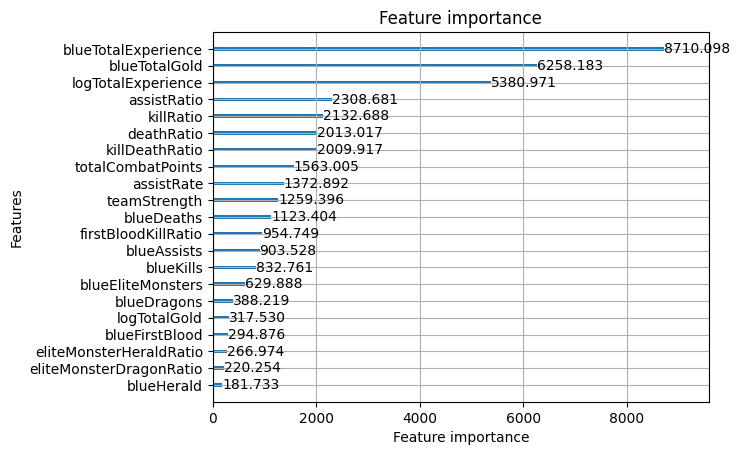

assistRatio: 1685
killRatio: 1628
deathRatio: 1612
killDeathRatio: 1359
totalCombatPoints: 1247
blueTotalGold: 1183
assistRate: 1148
teamStrength: 990
blueTotalExperience: 881
blueDeaths: 777
blueAssists: 677
firstBloodKillRatio: 614
blueKills: 523
blueEliteMonsters: 313
logTotalExperience: 282
blueDragons: 196
blueFirstBlood: 188
eliteMonsterDragonRatio: 161
logTotalGold: 161
eliteMonsterHeraldRatio: 111
blueHerald: 107


In [8]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)

# Optunaでのハイパーパラメータチューニング
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    verbose_eval = 0
    verbose = lgb.log_evaluation(verbose_eval)

    # 早期停止の設定
    early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=True)
    model = lgb.train(param, lgb_train, num_boost_round=1000, valid_sets=[lgb_val], callbacks=[early_stopping, verbose])
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_error'
best_params['verbosity'] = -1

lgb_train = lgb.Dataset(X, y)
model = lgb.train(best_params, lgb_train, num_boost_round=study.best_trial.number)

# テストデータに対する予測
y_test_pred = model.predict(test_drop_gameId)
y_test_pred_int = (y_test_pred > 0.5).astype(int)

# 予測結果の表示
print(y_test_pred_int)


# 特徴量の重要度をプロット
lgb.plot_importance(model, importance_type='gain', max_num_features=30)
plt.show()

# 特徴量の重要度を取得
importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

# 特徴量とその重要度をペアにして表示
feature_importances = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
for name, imp in feature_importances:
    print(f"{name}: {imp}")

- testにy_test_pred結合

In [9]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_submit_cv_oputuna_val.csv'

In [10]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': y_test_pred_int
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [11]:
check = pd.read_csv(output)

In [12]:
check

,9,1
0,15,1
1,18,0
2,23,0
3,31,0
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
